# Machine Learning Approach To Early Autism Diagnosis Using ATR-FTIR Spectroscopy

This project explores the application of machine learning algorithms for the early diagnosis of autism spectrum disorder (ASD) based on **Attenuated Total Reflection Fourier Transform Infrared (ATR-FTIR)** spectroscopy data.

The primary objective was to design a robust classification pipeline to handle high-dimensional spectral data derived from urine samples, aiming to improve non-invasive early detection outcomes.

#### 1.0 — Library Import

In [168]:
# Base Tools
import sys
import numpy as np
from numpy import trapezoid as trapz
from random import randint
import pandas as pd
import matplotlib.pyplot as plt

# Feature Engineering
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Optimization
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve,validation_curve,GridSearchCV

# Prediction
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Validation & Metrics
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,ConfusionMatrixDisplay

#### 2.0 — Control Tab

In [169]:
# Quick-set
setting = "Default" # Default Or Experimental

# Dynamic Parameters
if setting == "Default":
    sheet_param = "Raw Data" # Raw Data, First Derivative Or Second Derivative
    slice_param = "Full Interval" # Full Interval, Fingerprint Region, High-frequency Region Or Double Interval
    normalization_param = None # None Or Vector Normalization Or Area Normalization
    smoothing_param = "On" # On Or Off
    split_param = "Auto" # Auto Or Manual Or LOOCV
elif setting == "Experimental":
    sheet_param = str(input("Please insert the 'sheet_param': "))
    slice_param = str(input("Please insert the 'slice_param': "))
    normalization_param = str(input("Please insert the 'normalization_param': "))
    smoothing_param = str(input("Please insert the 'smoothing_param': "))
    split_param = str(input("Please insert the 'split_param': "))
else:
    print("Please select a valid parameter setting for 'setting'.")
    sys.exit()


# Feature Engineering Parameters
pca_param = "On" # On Or Off
pca_function = "Graph" # Graph Or Preprocess
pca_target = "Off" # On Or Off
if pca_target == "On":
    pca_target_samples = ["A1"]
elif pca_target == "Off":
    pass
else:
    print("Please select a valid parameter setting for 'pca_target'.")
    import sys
    sys.exit()

# Split Parameters
if split_param == "Auto":
    auto_test_size = 0.3
elif split_param == "Manual":
    manual_test_size = 17
elif split_param == "LOOCV":
    leave_one_out_reference = "A1"
else:
    print("Please select a valid parameter setting for 'split_param'.")
    import sys
    sys.exit()


# Cross-validation Parameter
cross_val_size = 13

#### 3.0 — Data Import

In [170]:
data = pd.DataFrame(pd.read_excel("Data/Data.xlsx", sheet_param))

#### 3.1 — Data Transpose

In [171]:
# The data has already been transposed, or there is no need to transpose the raw data.

#### 3.2 — Column Manipulation

In [172]:
# All the columns are in the right order and label, so there is no need to implement column manipulation.

#### 3.3 — Data Stats

In [173]:
total_features = len(list(data[data.columns[0]]))
print(f"The total number of people who have experimented is {total_features}.")

The total number of people who have experimented is 52.


In [174]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 2908 entries, Id to 3800.044
dtypes: float64(2906), str(2)
memory usage: 1.2 MB


In [175]:
data.describe()

599.753    600.717    601.682    602.646     603.61    604.574  \
count  52.000000  52.000000  52.000000  52.000000  52.000000  52.000000   
mean    0.844780   0.794423   0.774748   0.813123   0.801565   0.762592   
std     0.137690   0.140690   0.146239   0.133505   0.149399   0.126132   
min     0.551368   0.423344   0.489764   0.552528   0.345368   0.430164   
25%     0.751967   0.697435   0.667636   0.730084   0.730682   0.664220   
50%     0.841470   0.796951   0.771308   0.816974   0.802637   0.774450   
75%     0.953469   0.917365   0.867356   0.888232   0.871457   0.830105   
max     1.138955   1.054878   1.089377   1.132735   1.101094   1.079749   

         605.539    606.503    607.467    608.431  ...   3791.366   3792.331  \
count  52.000000  52.000000  52.000000  52.000000  ...  52.000000  52.000000   
mean    0.783516   0.756654   0.783091   0.754398  ...   0.005871   0.005771   
std     0.138734   0.131404   0.129034   0.156274  ...   0.001021   0.000910   
min     0.430158   0.478761   0.481317   0.432237  ...   0.003970   0.003389   
25%     0.693321   0.654133   0.696993   0.641632  ...   0.005069   0.005281   
50%     0.807764   0.763963   0.770091   0.743179  ...   0.006046   0.005838   
75%     0.871281   0.851505   0.854592   0.825767  ...   0.006596   0.006304   
max     1.100961   1.032050   1.058569   1.246542  ...   0.007980   0.008083   

        3793.295   3794.259   3795.223   3796.187   3797.152   3798.116  \
count  52.000000  52.000000  52.000000  52.000000  52.000000  52.000000   
mean    0.005915   0.005832   0.005733   0.005812   0.005758   0.005776   
std     0.000926   0.000919   0.000964   0.000944   0.000817   0.000815   
min     0.003085   0.004312   0.003938   0.003727   0.004093   0.004339   
25%     0.005305   0.005259   0.005068   0.005163   0.005101   0.005234   
50%     0.006033   0.005748   0.005687   0.005879   0.005671   0.005775   
75%     0.006554   0.006186   0.006318   0.006405   0.006436   0.006308   
max     0.007472   0.009196   0.007523   0.007682   0.008000   0.007712   

         3799.08   3800.044  
count  52.000000  52.000000  
mean    0.005947   0.005942  
std     0.000882   0.000828  
min     0.004146   0.004202  
25%     0.005347   0.005438  
50%     0.005953   0.005860  
75%     0.006648   0.006485  
max     0.007608   0.008133  

[8 rows x 2906 columns]

In [176]:
# This attribute simply determines how many vacant features are in the provided columns.
data.isna().sum()

Id          0
Status      0
599.753     0
600.717     0
601.682     0
           ..
3796.187    0
3797.152    0
3798.116    0
3799.08     0
3800.044    0
Length: 2908, dtype: int64

#### 4.0 — Population Sampling

In [177]:
# Since the data is short on total patients, there is no need for population sampling.

#### 4.1 — Feature Cleaning

In [178]:
id0001 = list(data["Id"])
status0001 = list(data["Status"])

data = data.drop(columns=["Id","Status"])

In [179]:
# This attribute simply outputs the rows that have vacant values in them.
agent = data[data.isna().any(axis=1)]
print(agent)

Empty DataFrame
Columns: [599.753, 600.717, 601.682, 602.646, 603.61, 604.574, 605.539, 606.503, 607.467, 608.431, 609.396, 610.36, 611.324, 612.288, 613.252, 614.217, 615.181, 616.145, 617.109, 618.074, 619.038, 620.002, 620.966, 621.931, 622.895, 623.859, 624.823, 625.788, 626.752, 627.716, 628.68, 629.644, 630.609, 631.573, 632.537, 633.501, 634.466, 635.43, 636.394, 637.358, 638.323, 639.287, 640.251, 641.215, 642.179, 643.144, 644.108, 645.072, 646.036, 647.001, 647.965, 648.929, 649.893, 650.858, 651.822, 652.786, 653.75, 654.715, 655.679, 656.643, 657.607, 658.571, 659.536, 660.5, 661.464, 662.428, 663.393, 664.357, 665.321, 666.285, 667.25, 668.214, 669.178, 670.142, 671.106, 672.071, 673.035, 673.999, 674.963, 675.928, 676.892, 677.856, 678.82, 679.785, 680.749, 681.713, 682.677, 683.642, 684.606, 685.57, 686.534, 687.498, 688.463, 689.427, 690.391, 691.355, 692.32, 693.284, 694.248, 695.212, ...]
Index: []

[0 rows x 2906 columns]


#### 4.2 — Feature Filtration

In [180]:
new_lengths = []
old_lengths = list(data.columns)

for i in old_lengths:
    new_data = int(i)
    new_lengths.append(new_data)

data.columns = new_lengths
if slice_param == "Full Interval":
    data = data.loc[:, 600:3801]
    new_lengths = list(data.columns)
elif slice_param  == "Fingerprint Region":
    data = data.loc[:, 800:1701]
    new_lengths = list(data.columns)
elif slice_param  == "High-frequency Region":
    data = data.loc[:, 2600:3001]
    new_lengths = list(data.columns)
elif slice_param  == "Double Interval":
    df1 = data.loc[:, 2600:3001]
    df2 = data.loc[:, 800:1701]
    data = pd.concat([df2,df1], axis = 1)
    new_lengths = list(data.columns)

wavelengths = list(data.columns)
total_features_of_wavelengths = len(wavelengths)
data = data.copy()
data["Id"] = list(id0001)

if pca_target == "On":
    pca_target_sample_indexes = []
    if len(pca_target_samples) == 1:
        pca_target_sample_indexes = [list(data["Id"]).index(pca_target_samples[0])]
    else:
        for i in pca_target_samples:
            pca_target_sample_indexes.append(list(data["Id"]).index(i))

#### 4.3 — Feature Scaling

In [181]:
# Since the data has already been scaled by rubber-band and baseline correction methods, there is no need to execute another scaling method or methods.

#### 5.0 — Graph: Cut Spectra

In [182]:
area, rreeff, max_y_detected = [], [], []

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(24, 13.5), dpi=720)
fig.subplots_adjust(wspace=0.05)

for i in id0001:
    crack = pd.DataFrame(data.loc[data["Id"] == i]).values.reshape(total_features_of_wavelengths+1,1).tolist()
    
    y = []
    rreeff.append(crack[-1][0])
    crack.pop(-1)

    for q in crack:
        y.append(q[0])
    x = wavelengths
    max_y_detected.append(max(y))
    
    ax1.plot(x,y,linewidth=1.5)
    ax2.plot(x,y,linewidth=1.5)

    # That spot we calculate integration, then we are going to graph it.
    a = round(trapz(y, dx=max(x)),3)
    area.append(a)

if (slice_param == "Full Interval") and (normalization_param == None):
    ax1.set_xlim(3800, 2300)
    ax2.set_xlim(1900, 600)
    ax1.set_ylim(0.0,1.4)
    ax2.set_ylim(0.0,1.4)

    ax1.set_xticks([3800, 3400, 3000, 2600, 2400, 2300])
    ax2.set_xticks([1900, 1800, 1400, 1000, 600])
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2,1.4])

    ax1.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)

    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ax1.tick_params(labelright=False)
    ax2.tick_params(labelleft=False)

    d = 0.005
    kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (-d, +d), **kwargs)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

    fig.suptitle("Spectra")
    fig.text(0.5, 0.04, "Wavenumbers (1/CM.)", ha="center")
    fig.text(0.04, 0.5, "Absorbance (A.U.)", va="center", rotation="vertical")

    plt.show()
else:
    print("The spectrum graph is only visible for default parameter setting.")

#### 5.1 — Graph: AUC Comparison

In [183]:
a, b = [], []
a0, b0 = [], []
for k,i,f in zip(status0001,id0001,area):
    if k == "A": # Negative label here.
        b.append(i)
        b0.append(f)
    else:
        a.append(i)
        a0.append(f)

if max(a0) > max(b0):
    max_area = max(a0)
else:
    max_area = max(b0)

c = []

for i in a:
    c.append(i)

for i in b:
    c.append(i)

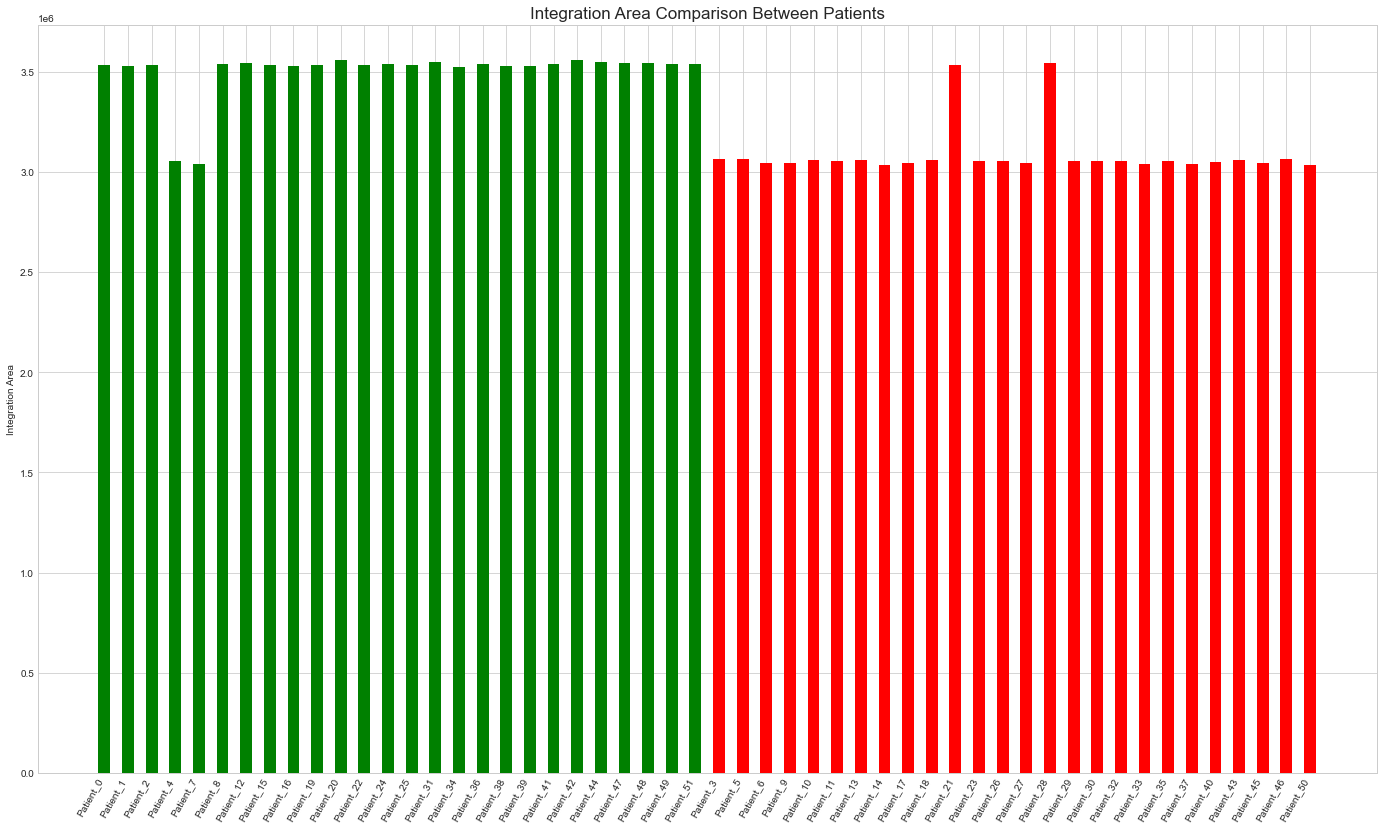

In [184]:
%%capture --no-display
plt.figure(figsize=(24,13.5), dpi= 72)

plt.bar(a, a0, color="green", width=0.5)
plt.bar(b, b0, color="red", width=0.5)
plt.gca().set_xticklabels(c, rotation=60, horizontalalignment="right")

plt.title("Integration Area Comparison Between Patients", fontsize=17)
plt.ylabel("Integration Area")
plt.show()

#### 6.0 — Feature Smoothing

In [185]:
data = data.drop(columns=["Id"])

if smoothing_param == "On":
    smoothing = savgol_filter(data, window_length=15, polyorder=3)
    data = pd.DataFrame(smoothing)

data.columns = new_lengths

#### 7.0 — Area Normalization

In [186]:
if normalization_param == "Area Normalization":
    for AAA,NNN in zip(list(data.index),area):
        data.iloc[AAA] = data.iloc[AAA]/NNN

#### 8.0 — Test N Train Split

In [187]:
if split_param == "Auto":
    x = data.values
    y = np.array(status0001)
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=auto_test_size, random_state=randint(0,1001))

    # Let"s define the big X and the big Y in terms of the full feature matrix.
    temporary_defined_variable = data
    temporary_defined_variable["Y"] = status0001
    Y = list(temporary_defined_variable["Y"])
    
    temporary_defined_variable = temporary_defined_variable.drop(columns=["Y"])
    X = temporary_defined_variable.values
    Y = np.array(Y)

elif split_param == "Manual":
    data["Y"] = status0001

    test_features = manual_test_size
    train_features = total_features - test_features

    train = data.iloc[:train_features,:]
    test = data.iloc[train_features:,:]

    train = train.drop(columns=["Y"])
    test = test.drop(columns=["Y"])

    x_train = train.values
    x_test = test.values

    # Let"s define the big X and the big Y in terms of the full feature matrix.
    temporary_defined_variable = data
    Y = list(temporary_defined_variable["Y"])
    
    temporary_defined_variable = temporary_defined_variable.drop(columns=["Y"])
    X = temporary_defined_variable.values
    Y = np.array(Y)

elif split_param == "LOOCV":
    data["Reference"] = id0001
    data["Y"] = status0001

    y_test, y_train = [], []
    x_test, x_train = [], []

    # Selecting the one & filling the y_test.
    YY = data.loc[data["Reference"] == leave_one_out_reference]
    YY = YY.drop(columns=["Reference"])
    y_test.append(list(YY["Y"])[0])

    # Leaving-one-out & filling the y_train.
    ref_index = list(data["Reference"]).index(leave_one_out_reference)
    XX = data.drop(ref_index)
    XX = XX.drop(columns=["Reference"])
    y_train = list(XX["Y"])

    # List type to numpy array type conversion.
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Extracting Y variable to convert dataframes into X.
    XX = XX.drop(columns=["Y"])
    YY = YY.drop(columns=["Y"])

    # Filling the x_train & x_test.
    x_train = XX.values
    x_test = YY.values

    # Let"s define the big X and the big Y in terms of the full feature matrix.
    temporary_defined_variable = data
    Y = list(temporary_defined_variable["Y"])
    
    temporary_defined_variable = temporary_defined_variable.drop(columns=["Reference","Y"])
    X = temporary_defined_variable.values
    Y = np.array(Y)

#### 9.0 — Vector Normalization

In [188]:
SCALER = StandardScaler()
if normalization_param == "Vector Normalization":
    x_train = SCALER.fit_transform(x_train)
    x_test = SCALER.transform(x_test)
else:
    pass

#### 10.0 — Label Encoding

In [189]:
y_train_new, y_test_new, Y_NEW = [], [], []

for i in list(y_train):
    if i == "H":
        y_train_new.append(0)
    elif i == "A":
        y_train_new.append(1)

for i in list(y_test):
    if i == "H":
        y_test_new.append(0)
    elif i == "A":
        y_test_new.append(1)

for i in list(Y):
    if i == "H":
        Y_NEW.append(0)
    elif i == "A":
        Y_NEW.append(1)

y_train = np.array(y_train_new)
y_test = np.array(y_test_new)
Y = np.array(Y_NEW)

# Statistical variable definition.
total_train_features = len(list(x_train))
total_test_features = len(list(x_test))
total_matrix_features = total_train_features + total_test_features

#### 11.0 — Feature Engineering

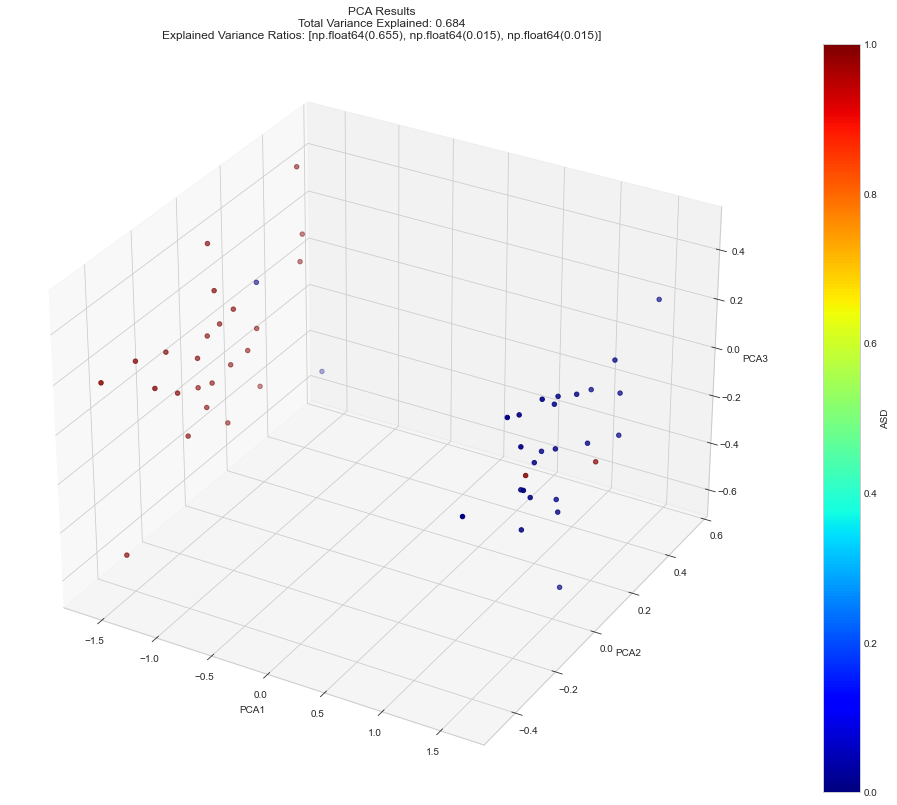

In [190]:
# In this research, n_components is a static parameter of 3 with no permission to change.
pca = PCA(n_components=3)

if pca_param == "On":
    if pca_function == "Preprocess":
        x_train = pca.fit_transform(x_train)
        x_test = pca.transform(x_test)
    else:
        pca = PCA(n_components=3)
        XPCA = pca.fit_transform(X)
        YPCA = Y
        
        if pca_target == "Off":
            pass
        else:
            if len(pca_target_sample_indexes) == 1:
                YPCA[pca_target_sample_indexes] = 2
            else:
                for i,z in zip(pca_target_sample_indexes, list(range(2,len(pca_target_sample_indexes)+2))):
                    YPCA[i] = z

        fig = plt.figure(figsize=(24,13.5), dpi= 72)
        ax = fig.add_subplot(111, projection="3d")
        scatter = ax.scatter(XPCA[:, 0], XPCA[:, 1], XPCA[:, 2], c=YPCA, cmap="jet")

        explained_variance_ratio = pca.explained_variance_ratio_
        evr = []
        for i in explained_variance_ratio:
            evr.append(round(i,3))
        total_variance_explained = np.sum(explained_variance_ratio)

        ax.set_xlabel("PCA1")
        ax.set_ylabel("PCA2")
        ax.set_zlabel("PCA3")
        ax.set_title(f"PCA Results\nTotal Variance Explained: {round(total_variance_explained,3)}\nExplained Variance Ratios: {evr}")
        fig.colorbar(scatter, label="ASD")

#### 12.0 — Hyperparamater Tuning

#### 12.1 — Grid Search

In [191]:
RBF_PARAMS = {}
POLY_PARAMS = {}
LINEAR_PARAMS = {}

def svc_grid_search(kernelx):
    param_grid = {
        "tol": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0],
        "gamma": [0.00001 ,0.0001 ,0.001, 0.01, 0.1, 0.5, 1]
    }

    grid_search = GridSearchCV(SVC(kernel=kernelx),param_grid,cv=cross_val_size)
    grid_search.fit(X, Y)
    best_params = grid_search.best_params_
    
    if kernelx == "rbf":
        RBF_PARAMS["tol"] = best_params["tol"]
        RBF_PARAMS["gamma"] = best_params["gamma"]
    elif kernelx == "poly":
        POLY_PARAMS["tol"] = best_params["tol"]
        POLY_PARAMS["gamma"] = best_params["gamma"]
    elif kernelx == "linear":
        LINEAR_PARAMS["tol"] = best_params["tol"]
        LINEAR_PARAMS["gamma"] = best_params["gamma"]

In [192]:
svc_grid_search("rbf")

In [193]:
svc_grid_search("poly")

In [194]:
svc_grid_search("linear")

In [195]:
learning_curve_k_fold_size = total_matrix_features//cross_val_size
MINKOWSKI_PARAMS = {}
EUCLIDEAN_PARAMS = {}
COSINE_PARAMS = {}

def knn_grid_search(metricx):
    param_grid = {
        "n_neighbors": list(range(1,learning_curve_k_fold_size+1)),
        "weights": ["uniform", "distance"]
    }
    
    grid_search = GridSearchCV(KNeighborsClassifier(algorithm="brute",metric=metricx),param_grid,cv=cross_val_size)
    grid_search.fit(X, Y)
    best_params = grid_search.best_params_

    if metricx == "minkowski":
        MINKOWSKI_PARAMS["n_neighbors"] = best_params["n_neighbors"]
        MINKOWSKI_PARAMS["weights"] = best_params["weights"]
    elif metricx == "euclidean":
        EUCLIDEAN_PARAMS["n_neighbors"] = best_params["n_neighbors"]
        EUCLIDEAN_PARAMS["weights"] = best_params["weights"]
    elif metricx == "cosine":
        COSINE_PARAMS["n_neighbors"] = best_params["n_neighbors"]
        COSINE_PARAMS["weights"] = best_params["weights"]
    
    # By-hand Optimization
    if (sheet_param == "Second Derivative") & (slice_param == "Full Interval"):
        MINKOWSKI_PARAMS["n_neighbors"] = 4
        EUCLIDEAN_PARAMS["n_neighbors"] = 4
        COSINE_PARAMS["n_neighbors"] = 4
    elif (sheet_param == "Second Derivative") & (slice_param == "Fingerprint Region"):
        MINKOWSKI_PARAMS["n_neighbors"] = 4
        EUCLIDEAN_PARAMS["n_neighbors"] = 4
        COSINE_PARAMS["n_neighbors"] = 4
    elif (sheet_param == "Second Derivative") & (slice_param == "High-frequency Region") & (normalization_param == "Area Normalization"):
        MINKOWSKI_PARAMS["n_neighbors"] = 4
        EUCLIDEAN_PARAMS["n_neighbors"] = 4
        COSINE_PARAMS["n_neighbors"] = 4
    elif (sheet_param == "Second Derivative") & (slice_param == "Double Interval") & (normalization_param == None):
        MINKOWSKI_PARAMS["n_neighbors"] = 4
        EUCLIDEAN_PARAMS["n_neighbors"] = 4
        COSINE_PARAMS["n_neighbors"] = 4
    elif (sheet_param == "Second Derivative") & (slice_param == "Double Interval") & (normalization_param == "Vector Normalization"):
        MINKOWSKI_PARAMS["n_neighbors"] = 4
        EUCLIDEAN_PARAMS["n_neighbors"] = 4
        COSINE_PARAMS["n_neighbors"] = 4
    elif (sheet_param == "Second Derivative") & (slice_param == "Double Interval") & (normalization_param == "Area Normalization"):
        MINKOWSKI_PARAMS["n_neighbors"] = 2
        EUCLIDEAN_PARAMS["n_neighbors"] = 2
        COSINE_PARAMS["n_neighbors"] = 2
    elif (sheet_param == "Raw Data") & (slice_param == "Fingerprint Region") & (normalization_param == None):
        COSINE_PARAMS["n_neighbors"] = 2
    elif (sheet_param == "Raw Data") & (slice_param == "Fingerprint Region") & (normalization_param == "Vector Normalization"):
        COSINE_PARAMS["n_neighbors"] = 2
    elif (sheet_param == "Raw Data") & (slice_param == "Fingerprint Region") & (normalization_param == "Area Normalization"):
        MINKOWSKI_PARAMS["n_neighbors"] = 2
        EUCLIDEAN_PARAMS["n_neighbors"] = 2
        COSINE_PARAMS["n_neighbors"] = 2
    # # #

In [196]:
knn_grid_search("minkowski")

In [197]:
knn_grid_search("euclidean")

In [198]:
knn_grid_search("cosine")

#### 12.2 — Validation Curve

In [199]:
def svc_validation_curve(model,hyperparameter_space,title,froms):
    param_range = hyperparameter_space
    train_scores, test_scores = validation_curve(model,X,Y,param_name="C",param_range=param_range,cv=cross_val_size)
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    THRESHOLD = round((4.01/100),3)
    OFFSET = round((4.01/100),3)
    
    score_diffs = np.abs(train_scores.mean(axis=1) - test_scores.mean(axis=1))
    valid_indices = np.where((score_diffs <= THRESHOLD) & (train_scores.mean(axis=1) >= OFFSET))[0]

    if (title == "SVC-RBF") & (sheet_param == "Raw Data") & (slice_param == "High-frequency Region") & (normalization_param == None):
        optimal_c_value = round(2.3,3)
        feedback = "Hand"
    else:
        try:
            optimal_c_index = valid_indices[np.argmax(test_scores.mean(axis=1)[valid_indices])]
            optimal_c_value = round(param_range[optimal_c_index],3)
            feedback = "Calculation"
        except:
            optimal_c_value = round(0.1,3)
            feedback = "Compulsory Decision"

    if title == "SVC-RBF":
        RBF_PARAMS["C"] = optimal_c_value
    elif title == "SVC-POLY":
        POLY_PARAMS["C"] = optimal_c_value
    elif title == "SVC-Linear":
        LINEAR_PARAMS["C"] = optimal_c_value

    # # # PLOTTING SECTION
    plt.figure(figsize=(24,13.5),dpi=72)
    plt.style.use("seaborn-v0_8-whitegrid")
    
    plt.plot(param_range, train_mean, label="Training Score", marker="o", markersize=3.25, linewidth=0.75, color="purple")
    plt.plot(param_range, test_mean, label="Cross-validation Score", marker="o", markersize=3.25, linewidth=0.75, color="orange")

    plt.ylim(0.5,1.0)
    plt.xticks([0.01,0.25,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.05])
    plt.xlabel("C")
    plt.ylabel("Score")
    plt.title(f"{title} Validation Curve\nChosen C Value By {feedback}: {optimal_c_value}\nChosen Gamma Value: {froms["gamma"]}\nChosen Tol. Value: {froms["tol"]}")
    plt.legend()
    plt.show()

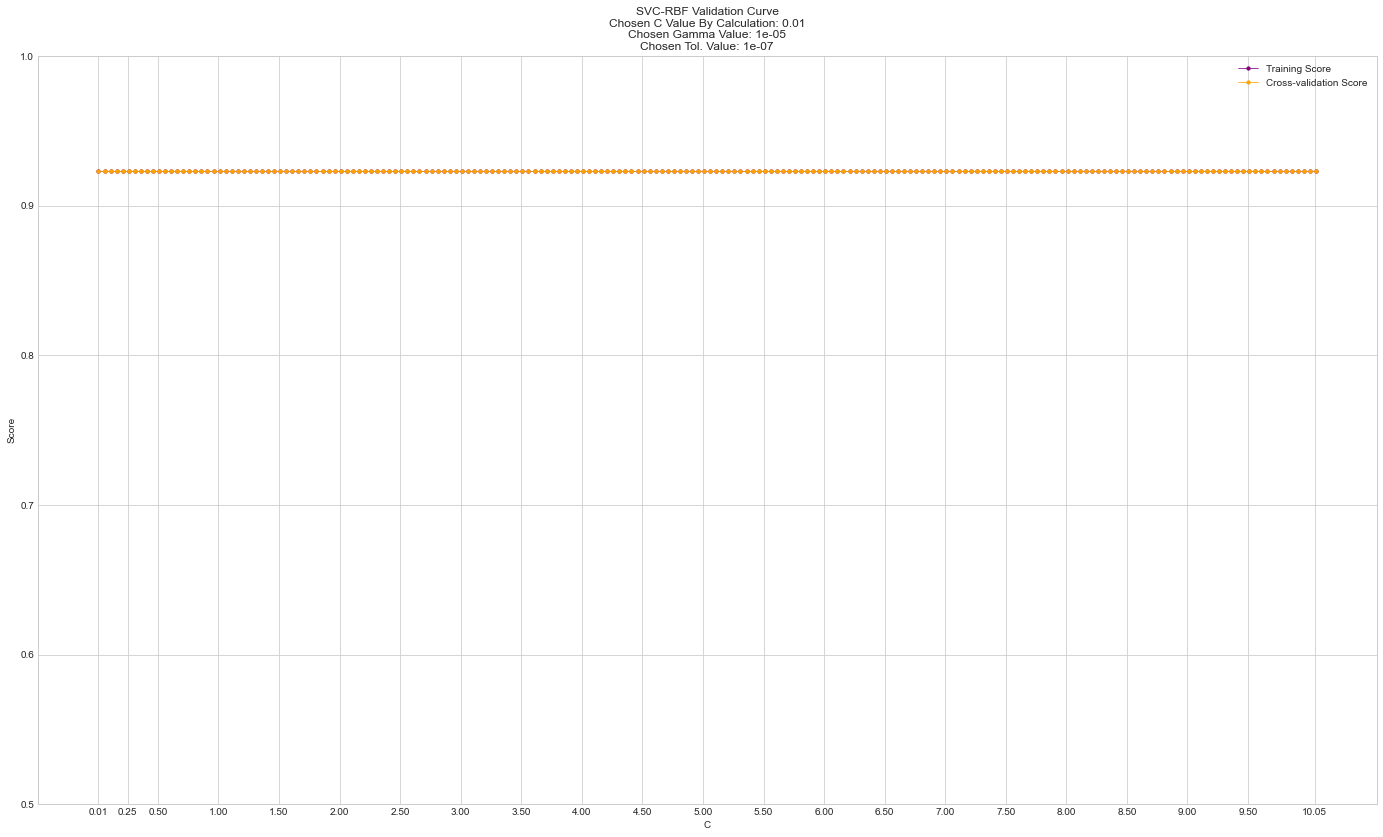

In [200]:
svc_validation_curve(SVC(kernel="rbf",gamma=RBF_PARAMS["gamma"],tol=RBF_PARAMS["tol"]),np.arange(0.01, 10.1, 0.05),"SVC-RBF",RBF_PARAMS)

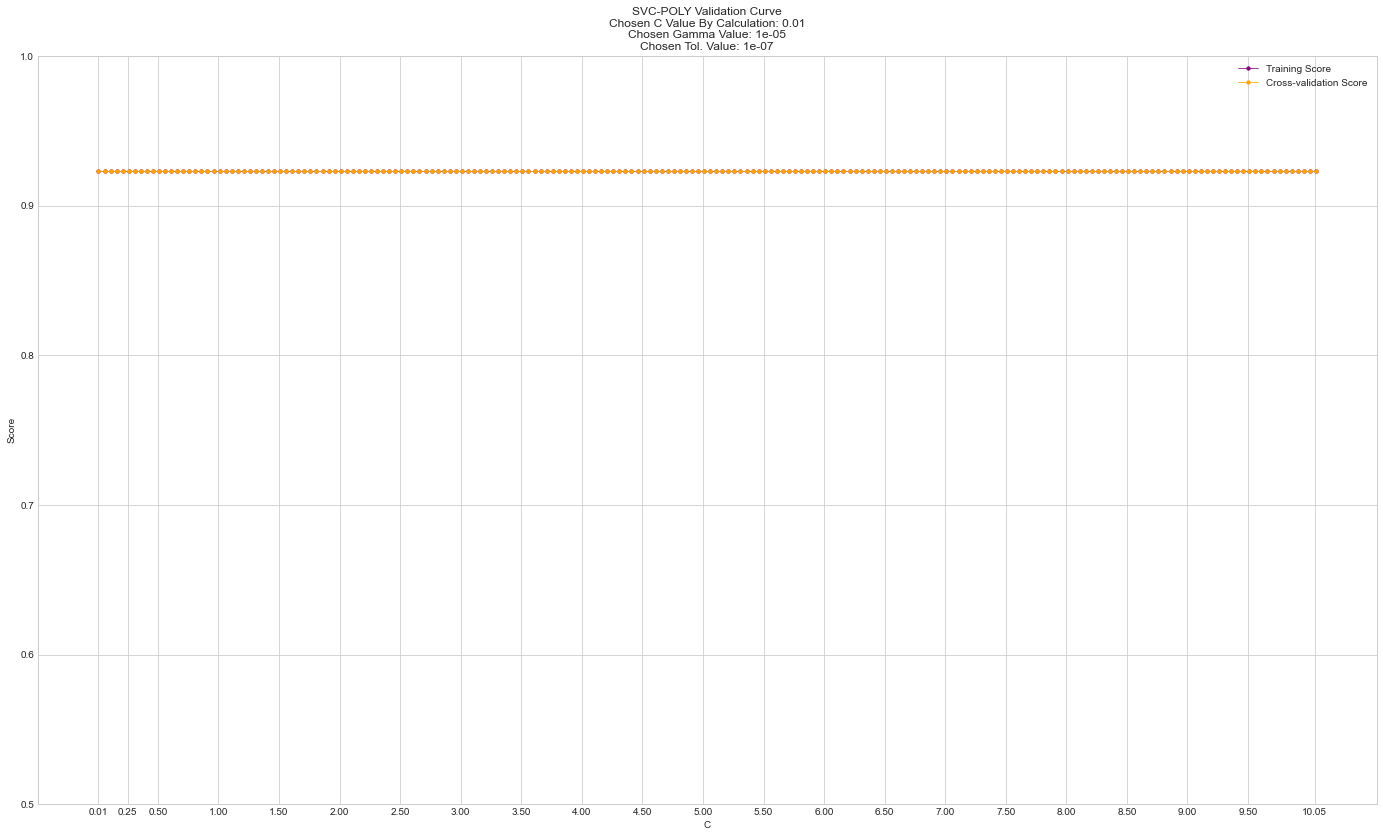

In [201]:
svc_validation_curve(SVC(kernel="poly",gamma=POLY_PARAMS["gamma"],tol=POLY_PARAMS["tol"]),np.arange(0.01, 10.1, 0.05),"SVC-POLY",POLY_PARAMS)

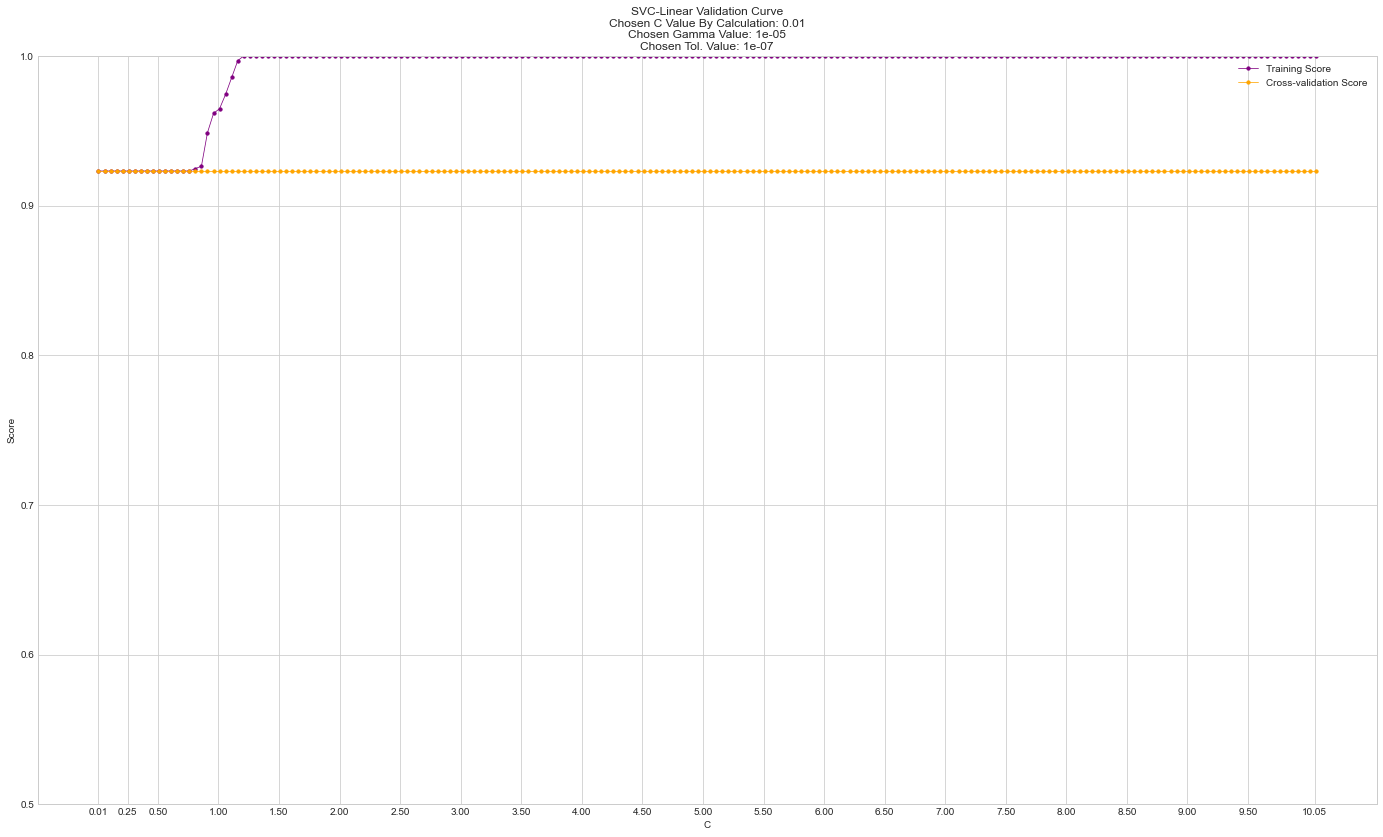

In [202]:
svc_validation_curve(SVC(kernel="linear",gamma=LINEAR_PARAMS["gamma"],tol=LINEAR_PARAMS["tol"]),np.arange(0.01, 10.1, 0.05),"SVC-Linear",LINEAR_PARAMS)

In [203]:
def knn_validation_curve(model,hyperparameter_space,title,froms):
    param_range = hyperparameter_space
    train_scores, test_scores = validation_curve(model,X,Y,param_name="n_neighbors",param_range=param_range,cv=cross_val_size)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(24,13.5),dpi=72)
    plt.style.use("seaborn-v0_8-whitegrid")
    
    plt.plot(param_range, train_mean, label="Training Score", marker="o", color="blue")
    plt.plot(param_range, test_mean, label="Cross-validation Score", marker="o", color="green")
    
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="green")

    plt.xticks(list(range(1,len(param_range)+1)))
    plt.xlabel("k-Neighbors")
    plt.ylabel("Score")
    plt.title(f"{title} Validation Curve\nOptimal Neighbors: {froms["n_neighbors"]}\nOptimal Weight Distribution: {froms["weights"].capitalize()}")
    plt.legend()
    plt.show()

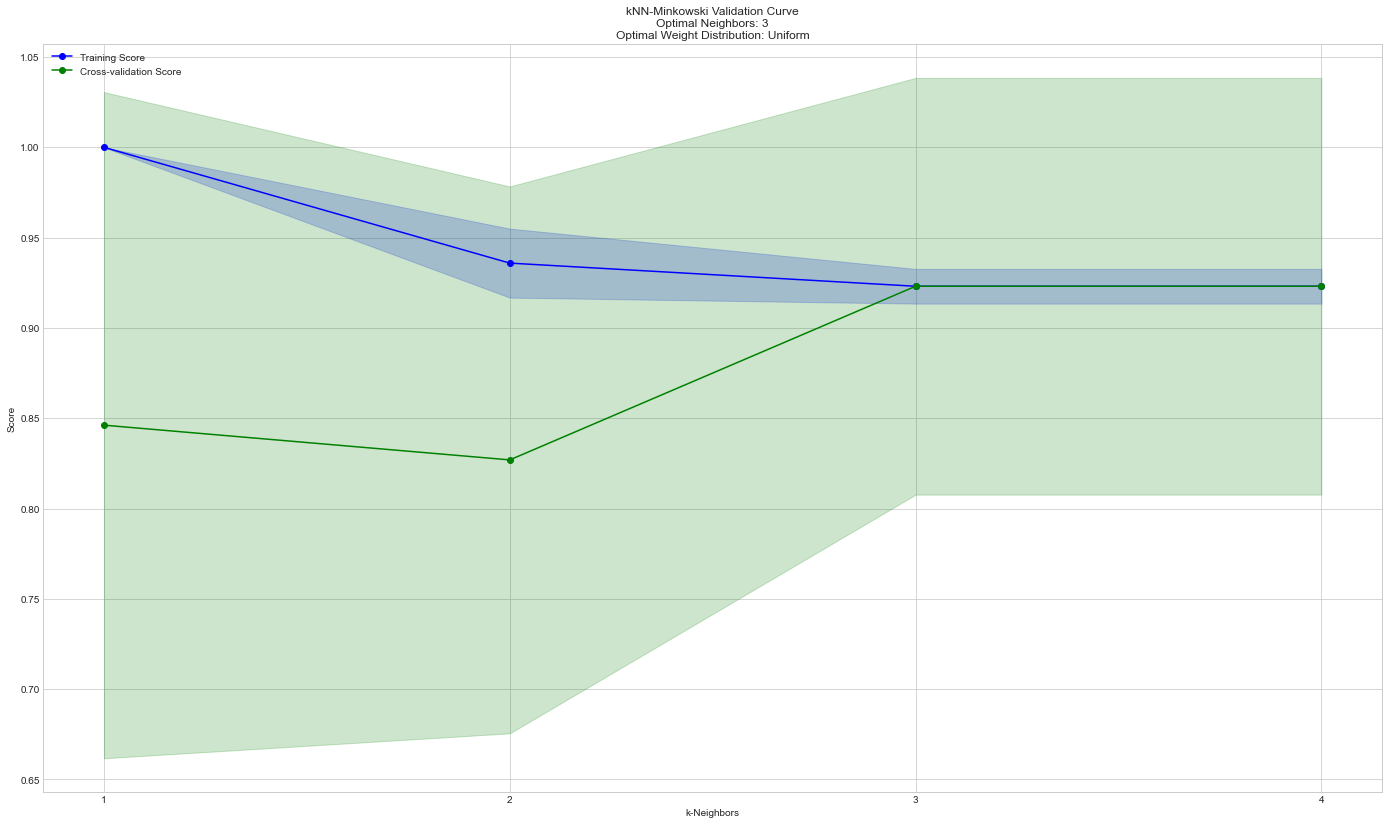

In [204]:
knn_validation_curve(KNeighborsClassifier(algorithm="brute",metric="minkowski",weights=MINKOWSKI_PARAMS["weights"]),list(range(1,learning_curve_k_fold_size+1)),"kNN-Minkowski",MINKOWSKI_PARAMS)

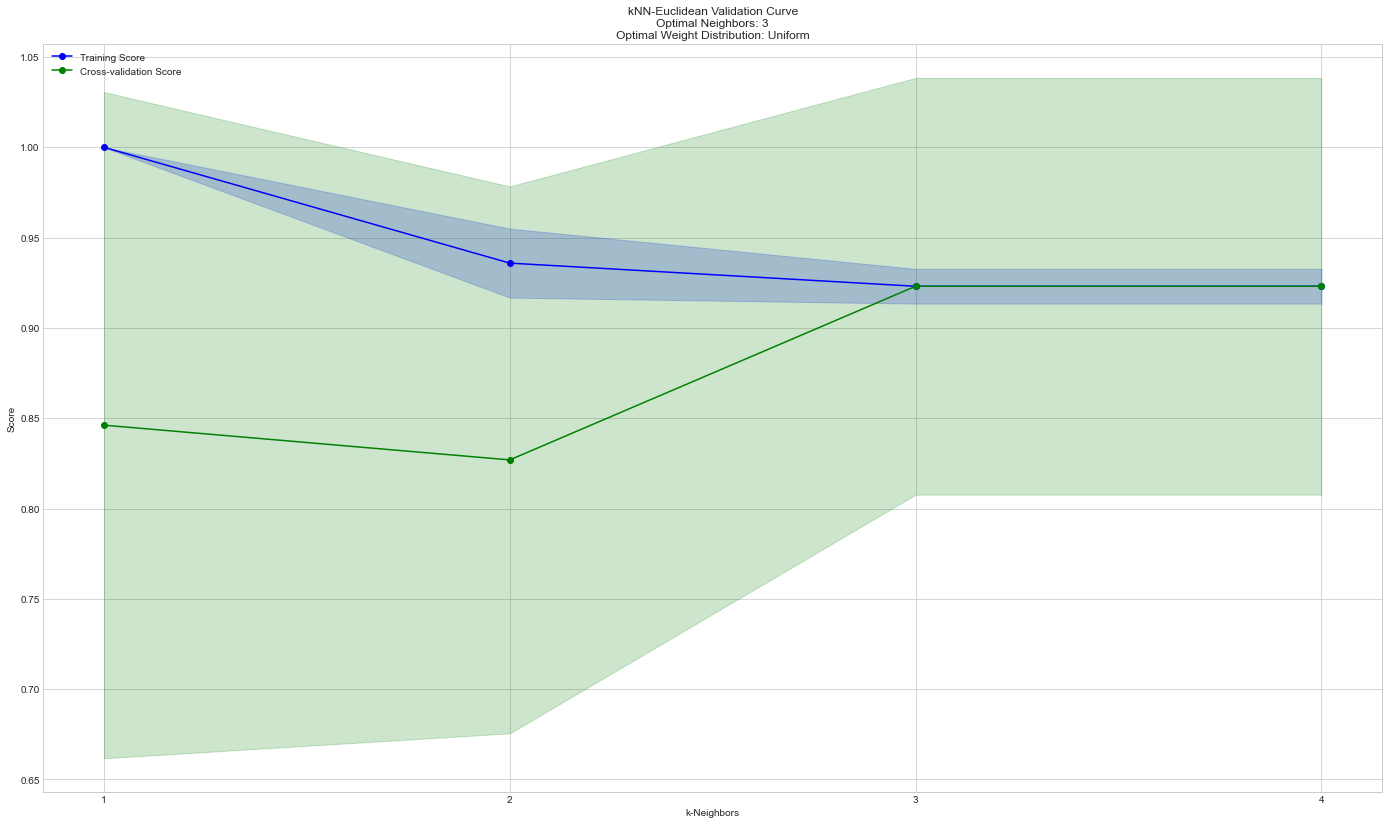

In [205]:
knn_validation_curve(KNeighborsClassifier(algorithm="brute",metric="euclidean",weights=EUCLIDEAN_PARAMS["weights"]),list(range(1,learning_curve_k_fold_size+1)),"kNN-Euclidean",EUCLIDEAN_PARAMS)

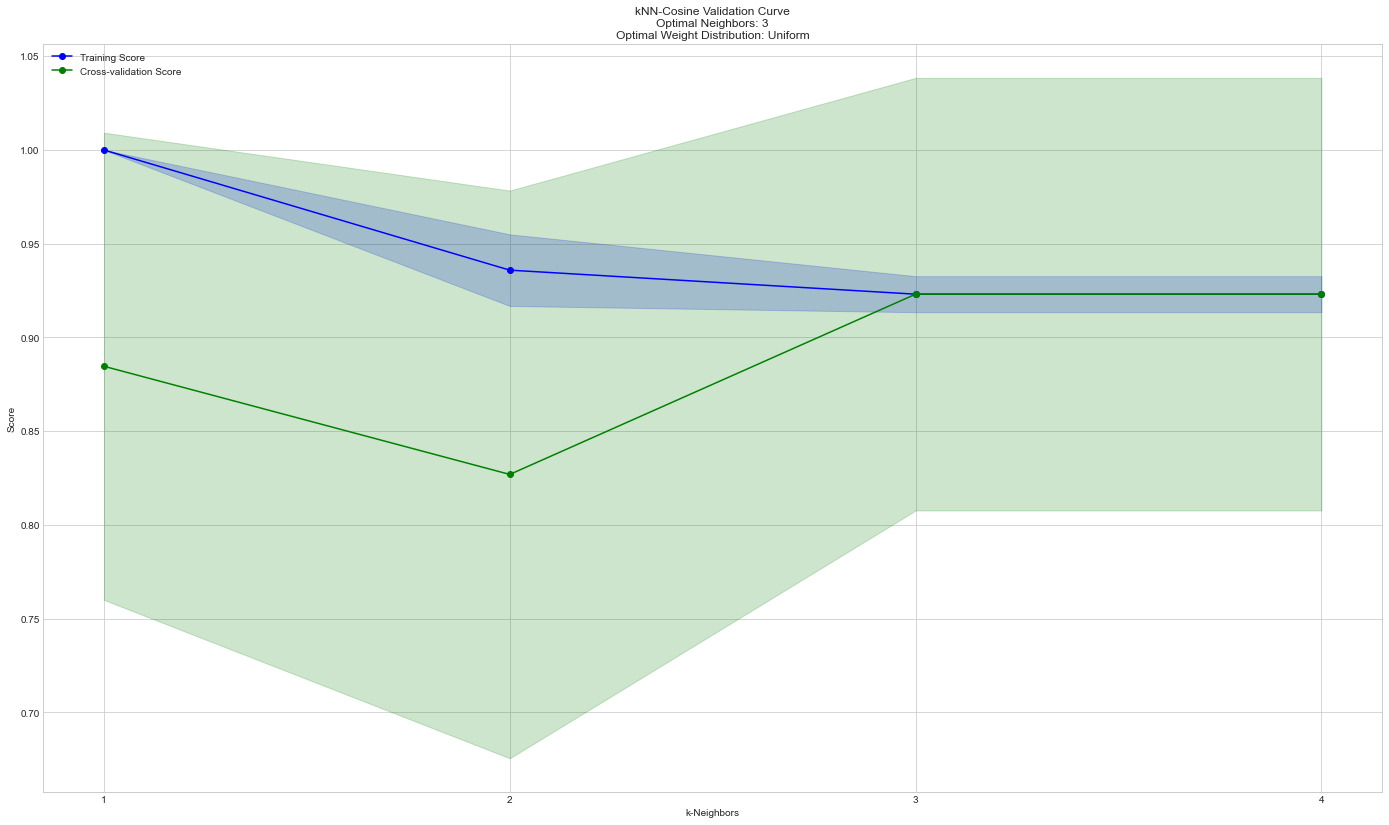

In [206]:
knn_validation_curve(KNeighborsClassifier(algorithm="brute",metric="cosine",weights=COSINE_PARAMS["weights"]),list(range(1,learning_curve_k_fold_size+1)),"kNN-Cosine",COSINE_PARAMS)

#### 13.0 — Model Selection

In [207]:
# SVM
SVC_RBF = SVC(kernel="rbf",gamma=RBF_PARAMS["gamma"],tol=RBF_PARAMS["tol"],C=RBF_PARAMS["C"])
SVC_POLY = SVC(kernel="poly",gamma=POLY_PARAMS["gamma"],tol=POLY_PARAMS["tol"],C=POLY_PARAMS["C"])
SVC_LINEAR = SVC(kernel="linear",gamma=LINEAR_PARAMS["gamma"],tol=LINEAR_PARAMS["tol"],C=LINEAR_PARAMS["C"])

# kNN
KNN_MINKOWSKI = KNeighborsClassifier(algorithm="brute",metric="minkowski",n_neighbors=MINKOWSKI_PARAMS["n_neighbors"],weights=MINKOWSKI_PARAMS["weights"])
KNN_EUCLIDEAN = KNeighborsClassifier(algorithm="brute",metric="euclidean",n_neighbors=EUCLIDEAN_PARAMS["n_neighbors"],weights=EUCLIDEAN_PARAMS["weights"])
KNN_COSINE = KNeighborsClassifier(algorithm="brute",metric="cosine",n_neighbors=COSINE_PARAMS["n_neighbors"],weights=COSINE_PARAMS["weights"])

#### 13.1 — Model Training

In [208]:
def resume(model, title):
    model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    
    # # #
    
    ACC = round(accuracy_score(y_test, y_predicted)*100,3)
    cv_scores = cross_val_score(estimator = model, X = X, y = Y, cv = cross_val_size)
    train_score = model.score(X, Y)

    # # #

    print(f"\n{title}\nAccuracy: %{ACC}\nTraining Score: %{round(train_score*100,3)}\n{cross_val_size}-fold Cross-validation Score: %{round(cv_scores.mean()*100,3)}\n")
    print(f"T: {y_test}\nP: {y_predicted}")
    print("\nConfusion Matrix Placement:\nTN - FP\nFN - TP")
    CM = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predicted))
    fig, ax = plt.subplots()
    CM.plot(cmap=plt.cm.Blues, values_format="d", ax=ax)
    ax.grid(False)
    plt.show()

In [209]:
def LR(model, title):
    # # # Learning Curve
    train_sizes = list(np.arange((total_matrix_features//cross_val_size),(total_matrix_features),(total_matrix_features//cross_val_size)))    
    train_sizes_abs, train_scores, test_scores = learning_curve(model, X, Y, cv=cross_val_size, train_sizes=train_sizes, scoring="accuracy", n_jobs=1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(16,9),dpi=72)
    plt.style.use("seaborn-v0_8-whitegrid")
    
    plt.plot(train_sizes_abs, train_scores_mean, label="Training Score", color="blue", marker="o")
    plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2, color="blue")

    plt.plot(train_sizes_abs, test_scores_mean, label="Cross-validation Score", color="green", marker="o")
    plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.2, color="green")

    plt.title(f"{title} Learning Curve")
    plt.xticks(train_sizes)
    plt.xlabel("Training Size")
    plt.ylabel("Rating")
    plt.legend(loc="best")
    plt.show()

    # # # ROC Curve
    if title[0] == "s":
        y_scoresx = model.decision_function(x_test)

        FPR, TPR, thresholds = roc_curve(y_test, y_scoresx)
        roc_auc = auc(FPR, TPR)

        plt.figure(figsize=(16,9),dpi=72)
        plt.plot(FPR, TPR, color="darkorange", lw=2, label="ROC Curve (area = %0.2f)" %roc_auc)
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{title} Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.show()

#### 14.0 — Classification Evalutation


SVC-RBF
Accuracy: %43.75
Training Score: %50.0
13-fold Cross-validation Score: %92.308

T: [0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0]
P: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Confusion Matrix Placement:
TN - FP
FN - TP


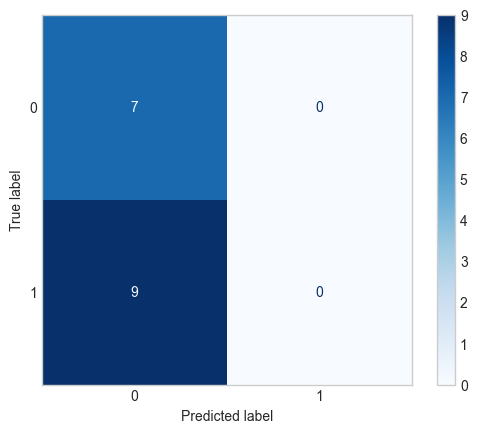

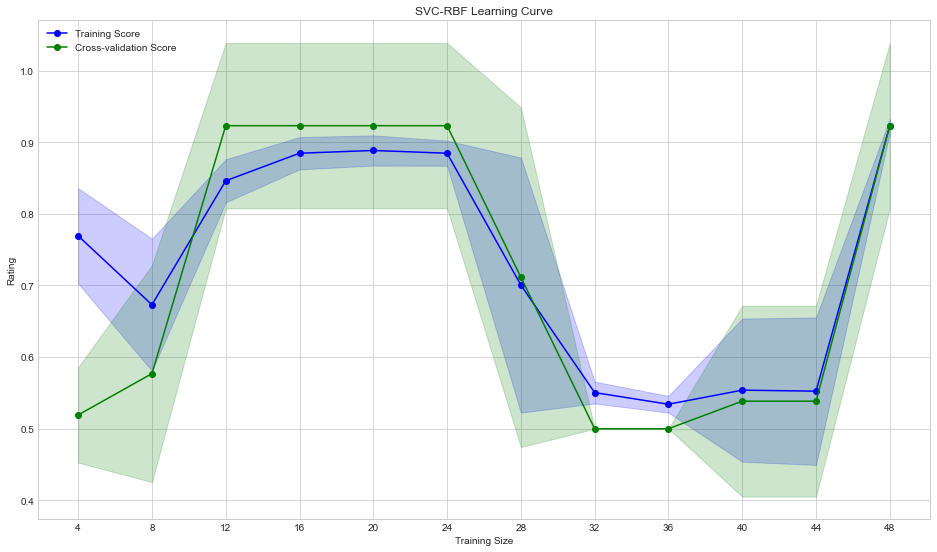

In [210]:
resume(SVC_RBF,"SVC-RBF")
LR(SVC_RBF,"SVC-RBF")


SVC-POLY
Accuracy: %43.75
Training Score: %50.0
13-fold Cross-validation Score: %92.308

T: [0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0]
P: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Confusion Matrix Placement:
TN - FP
FN - TP


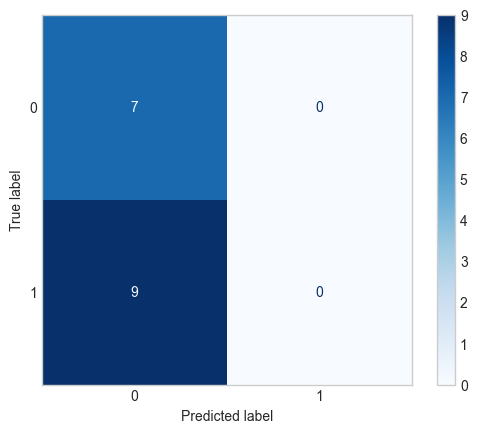

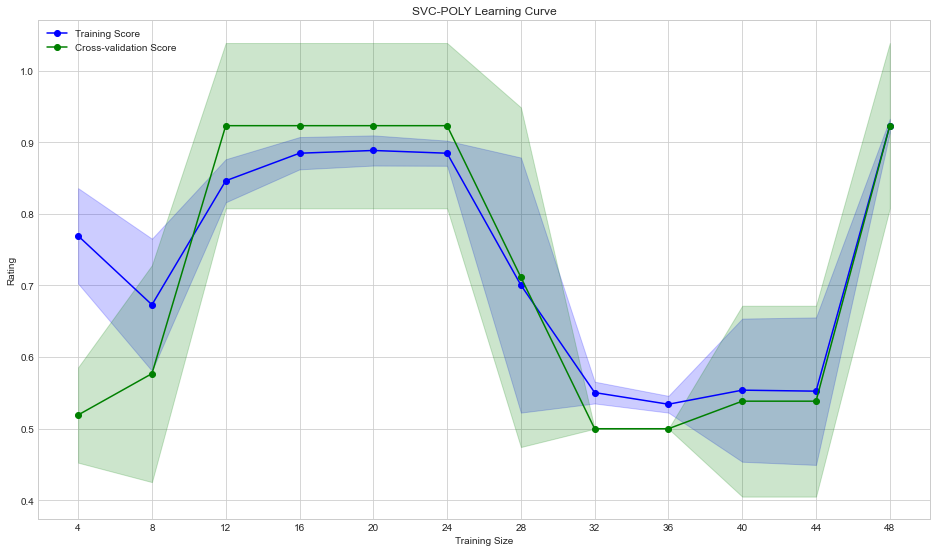

In [211]:
resume(SVC_POLY,"SVC-POLY")
LR(SVC_POLY,"SVC-POLY")


SVC-Linear
Accuracy: %87.5
Training Score: %92.308
13-fold Cross-validation Score: %92.308

T: [0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0]
P: [0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0]

Confusion Matrix Placement:
TN - FP
FN - TP


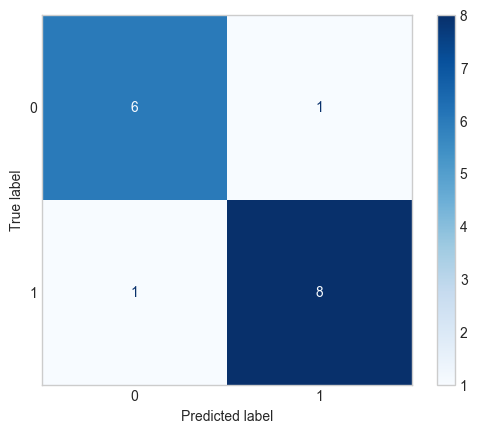

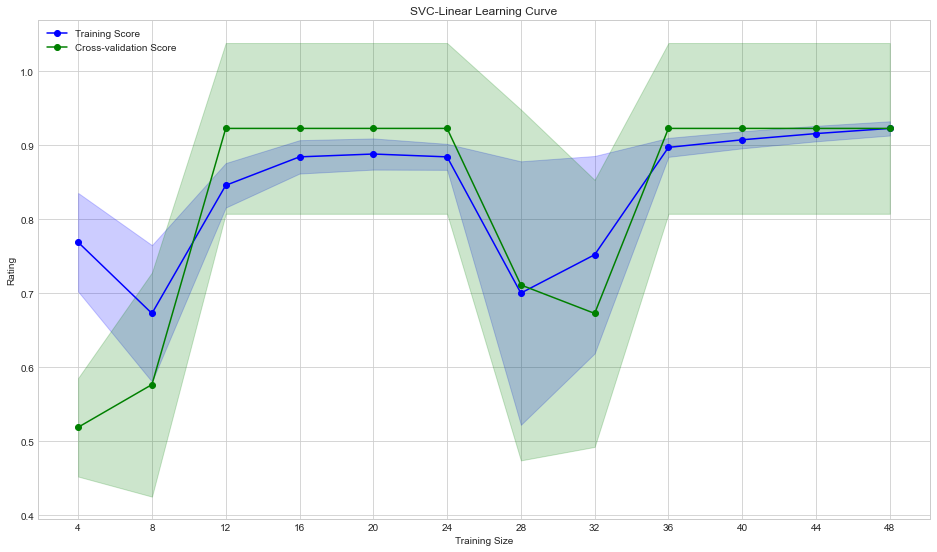

In [212]:
resume(SVC_LINEAR,"SVC-Linear")
LR(SVC_LINEAR,"SVC-Linear")


kNN-Minkowski
Accuracy: %87.5
Training Score: %92.308
13-fold Cross-validation Score: %92.308

T: [0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0]
P: [0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0]

Confusion Matrix Placement:
TN - FP
FN - TP


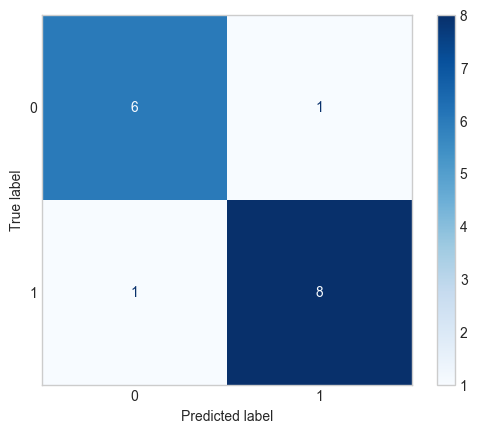

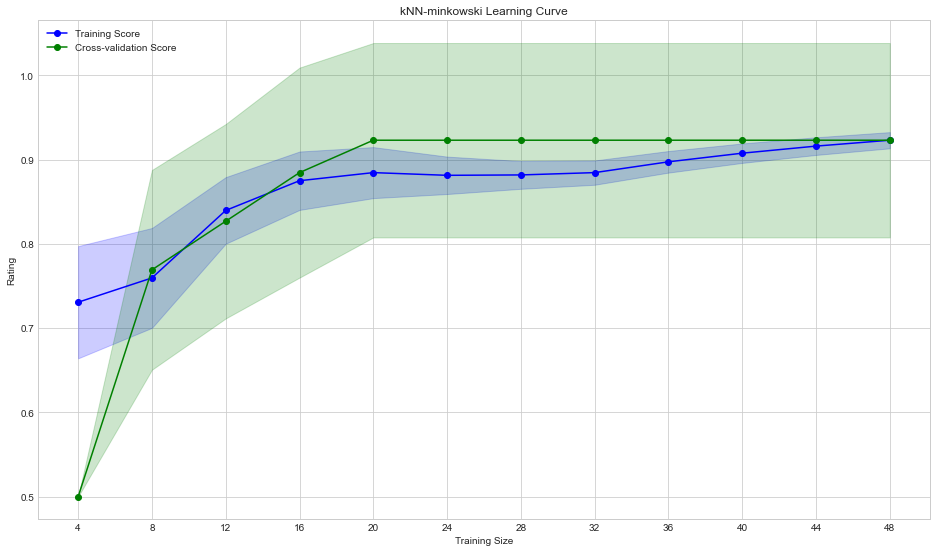

In [213]:
resume(KNN_MINKOWSKI,"kNN-Minkowski")
LR(KNeighborsClassifier(metric="minkowski",n_neighbors=learning_curve_k_fold_size,weights=MINKOWSKI_PARAMS["weights"]),"kNN-minkowski")


kNN-Euclidean
Accuracy: %87.5
Training Score: %92.308
13-fold Cross-validation Score: %92.308

T: [0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0]
P: [0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0]

Confusion Matrix Placement:
TN - FP
FN - TP


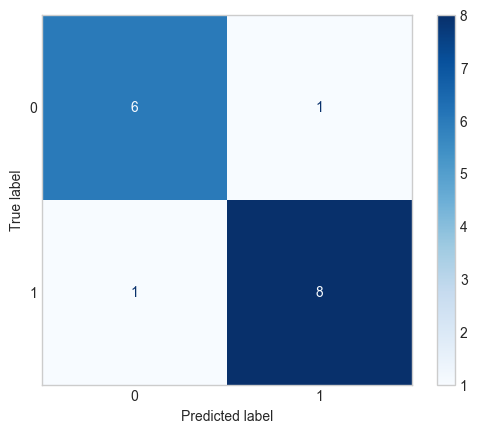

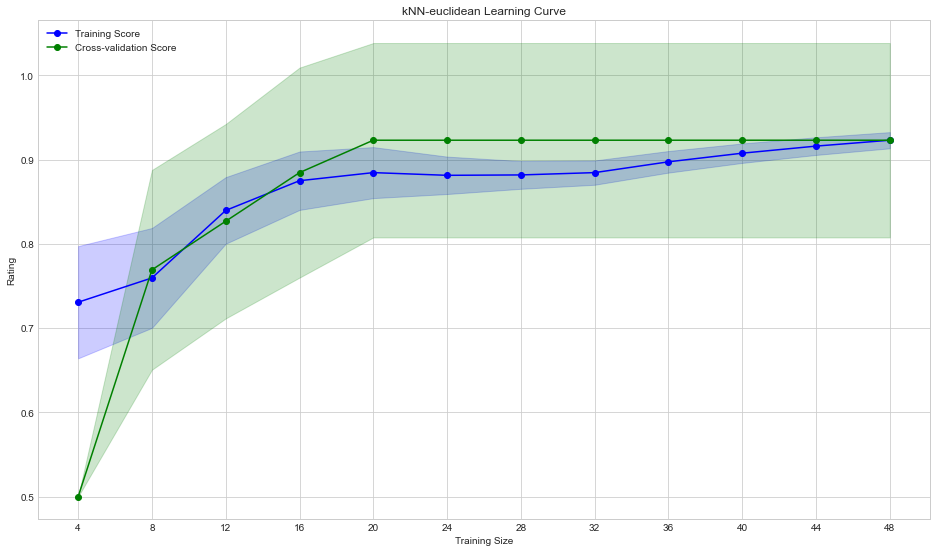

In [214]:
resume(KNN_EUCLIDEAN,"kNN-Euclidean")
LR(KNeighborsClassifier(metric="euclidean",n_neighbors=learning_curve_k_fold_size,weights=EUCLIDEAN_PARAMS["weights"]),"kNN-euclidean")


kNN-Cosine
Accuracy: %87.5
Training Score: %92.308
13-fold Cross-validation Score: %92.308

T: [0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0]
P: [0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0]

Confusion Matrix Placement:
TN - FP
FN - TP


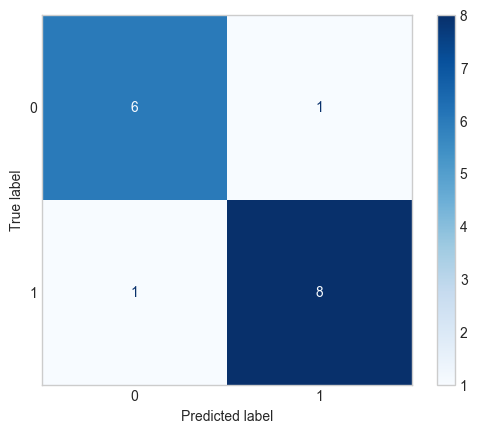

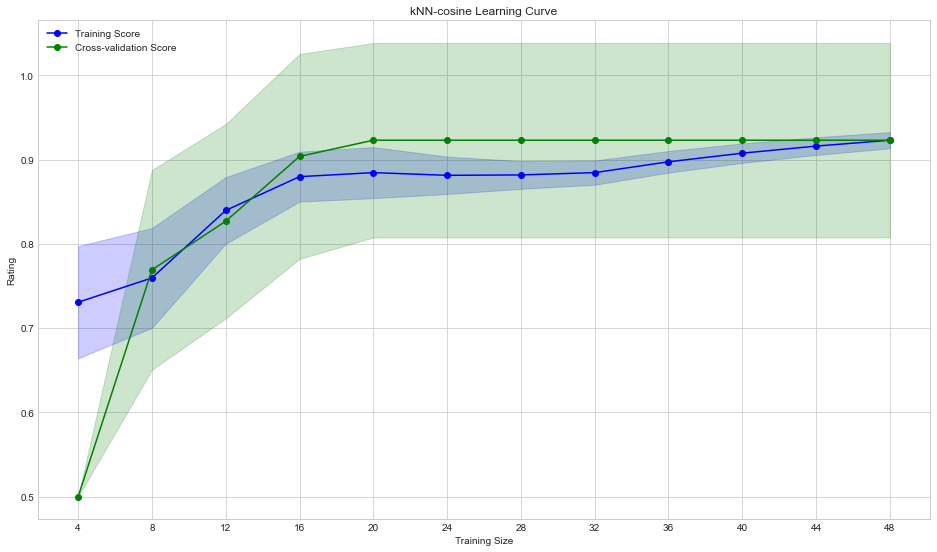

In [215]:
resume(KNN_COSINE,"kNN-Cosine")
LR(KNeighborsClassifier(metric="cosine",n_neighbors=learning_curve_k_fold_size,weights=COSINE_PARAMS["weights"]),"kNN-cosine")